<a href="https://colab.research.google.com/github/BartekFranczak/CPO---MEL/blob/main/cpo_lab5_HoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zaladowana baza danych

In [6]:
# Wczytanie bazy obrazów
import os
from zipfile import ZipFile

def readCPOdataset(datasetPath):
  with ZipFile(datasetPath, 'r') as zip:
    zip.extractall()
  folder = os.path.dirname(datasetPath)  

  trainImg = [os.path.join(folder + '/train_img', f) for f in os.listdir(folder + '/train_img') if os.path.isfile(os.path.join(folder + '/train_img', f))]
  testImg = [os.path.join(folder + '/test_img', f) for f in os.listdir(folder + '/test_img') if os.path.isfile(os.path.join(folder + '/test_img', f))]
  trainImg.sort()
  testImg.sort() 

  def readLabelFile(path):
    labels = []
    with open(path,'r') as f:
      labels = f.readlines()
      labels = [int(x.rstrip('\n')) for x in labels]
    return labels 
  trainLabels = readLabelFile(folder + '/train.txt')
  testLabels = readLabelFile(folder + '/test.txt')  

  return trainImg, testImg, trainLabels, testLabels

trainImg, testImg, trainLabels, testLabels = readCPOdataset('/content/dataset.zip')
print(f"Ścieżki do danych uczących: {trainImg}\nŚcieżki do danych walidacyjnych: {testImg}")
print(f"Etykiety danych uczących: {trainLabels}\nEtykiety danych walidacyjnych: {testLabels}")


Ścieżki do danych uczących: ['/content/train_img/00.png', '/content/train_img/01.png', '/content/train_img/02.png', '/content/train_img/03.png', '/content/train_img/04.png', '/content/train_img/05.png', '/content/train_img/06.png', '/content/train_img/07.png', '/content/train_img/08.png', '/content/train_img/09.png', '/content/train_img/10.png', '/content/train_img/11.png', '/content/train_img/12.png', '/content/train_img/13.png', '/content/train_img/14.png', '/content/train_img/15.png', '/content/train_img/16.png', '/content/train_img/17.png', '/content/train_img/18.png', '/content/train_img/19.png', '/content/train_img/20.png', '/content/train_img/21.png', '/content/train_img/22.png', '/content/train_img/23.png', '/content/train_img/24.png', '/content/train_img/25.png', '/content/train_img/26.png', '/content/train_img/27.png', '/content/train_img/28.png', '/content/train_img/29.png', '/content/train_img/30.png', '/content/train_img/31.png', '/content/train_img/32.png', '/content/trai

**ZADANIE 1**

# Wstępne przetworzenie obrazu:
- dostosowanie rozmiaru


1. Sprawdzam wielkośći zdjęć w zbiorach testowych i treningowych 

In [7]:
import cv2

def get_image_width(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    height, width = img.shape[:2]
    return width
def get_image_height(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    height, width = img.shape[:2]
    return height



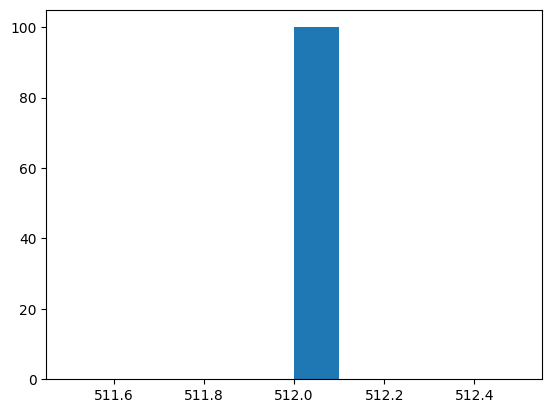

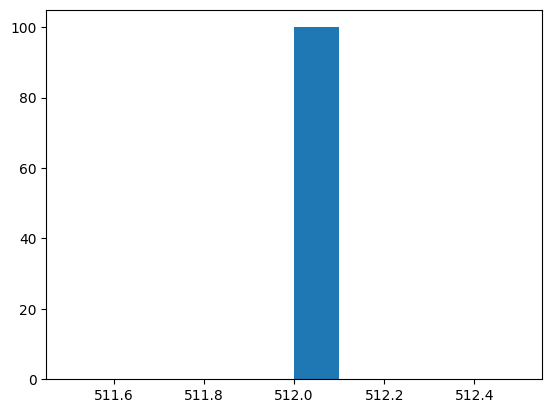

In [8]:
import matplotlib.pyplot as plt
import numpy as np

widths = [get_image_width(f) for f in trainImg] + [get_image_width(f) for f in testImg]
heights = [get_image_height(f) for f in trainImg] + [get_image_height(f) for f in testImg]

plt.hist(np.asarray(widths))
plt.show()
plt.hist(np.asarray(heights))
plt.show()

Wszystkie obrazy są w rozdzielczośći 512 x 512. W programie przeskaluje obrazy do rozdzielczośći 256x256 aby zwiększyć szybkość programu ale, żeby zachować jak najwięcej informacji.


In [9]:
from google.colab.patches import cv2_imshow
def show_img_bin(img_paths, sp_filter):
  for path in img_paths:

    img = np.asarray(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
    img = cv2.GaussianBlur(img,(7,7),0.9)
      
    binary_img = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
    if sp_filter:
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
      binary_img = cv2.dilate(binary_img,kernel,iterations = 1)
      binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
      binary_img = cv2.erode(binary_img,kernel,iterations = 1)
    cv2_imshow(binary_img)

In [10]:
def load_imgs(path_list, im_size):
  images = []
  dim = (im_size, im_size)
  for path in path_list:
    img = cv2.imread(path)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    images.append(img)
  return images   

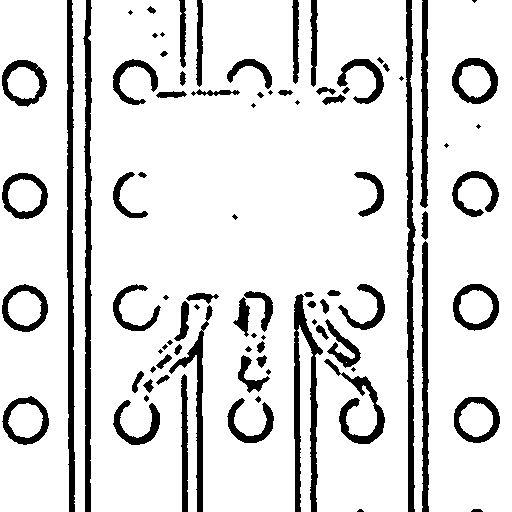

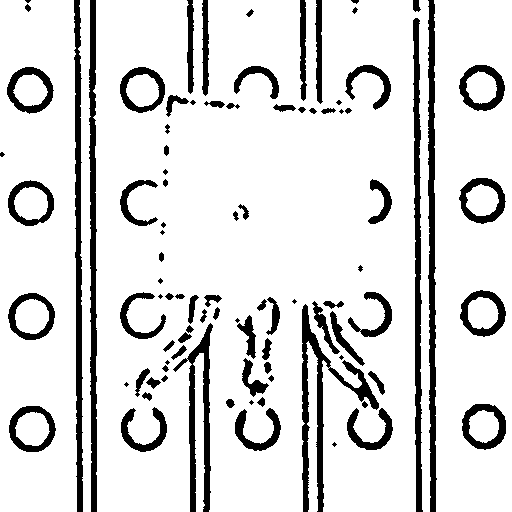

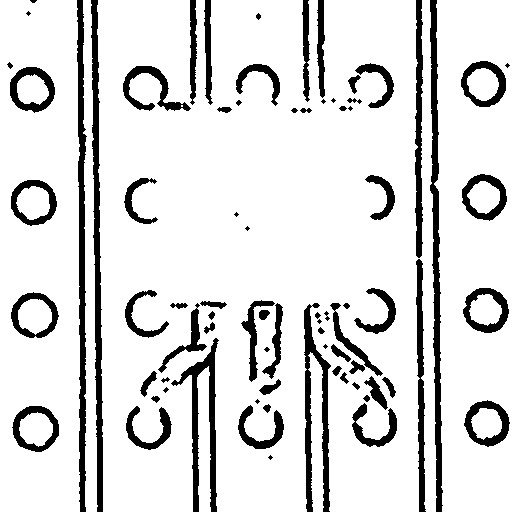

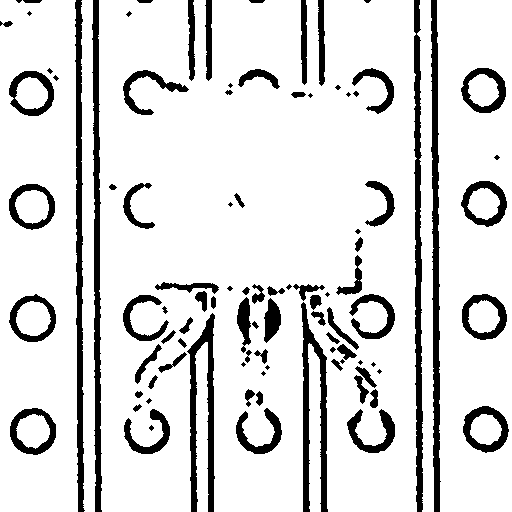

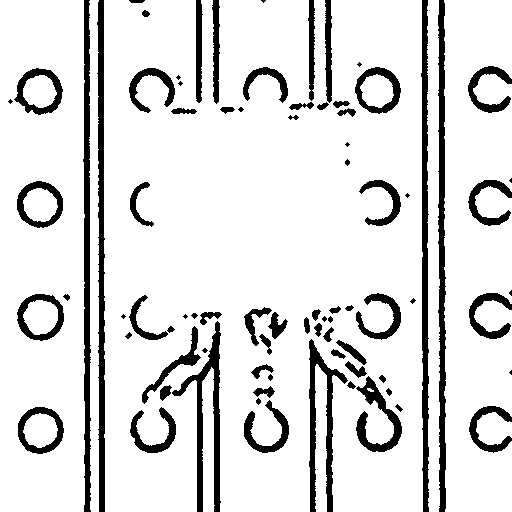

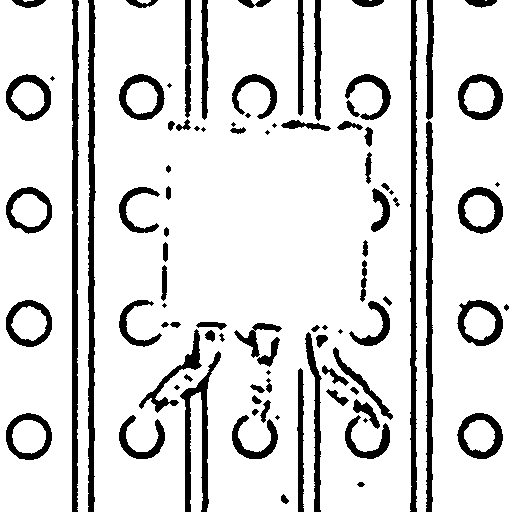

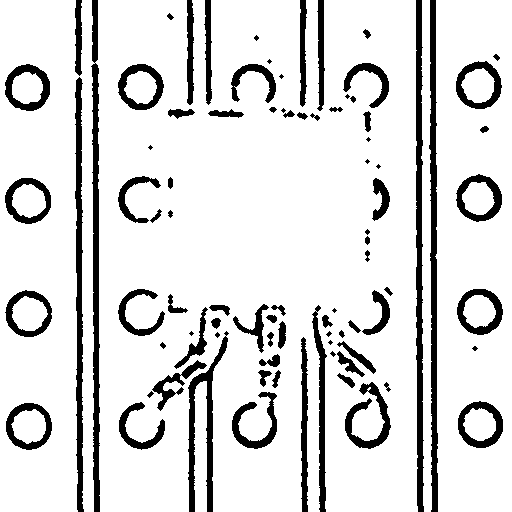

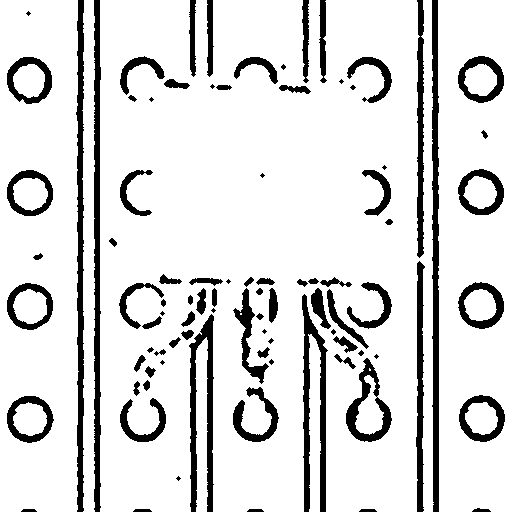

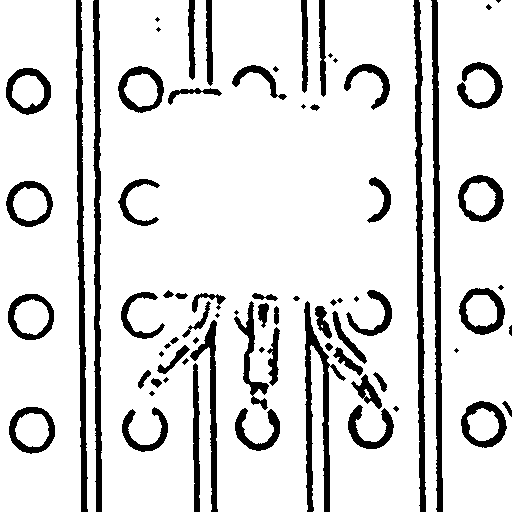

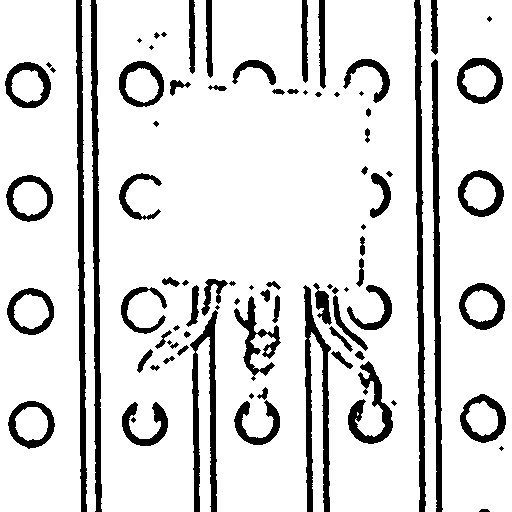

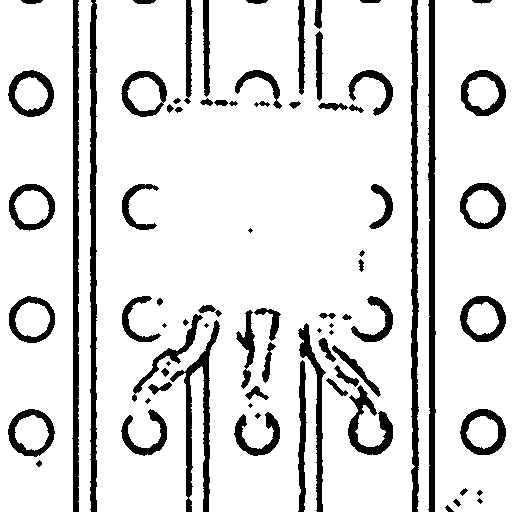

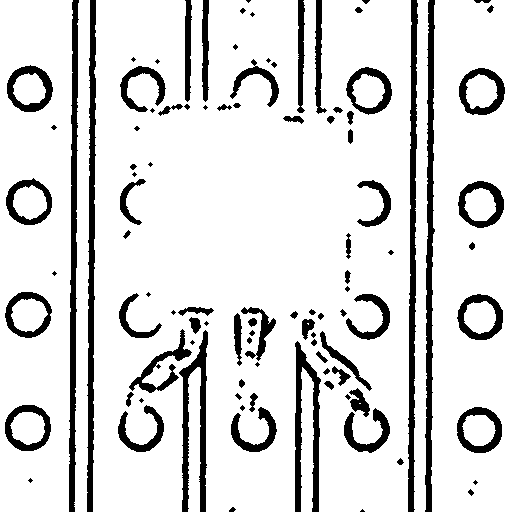

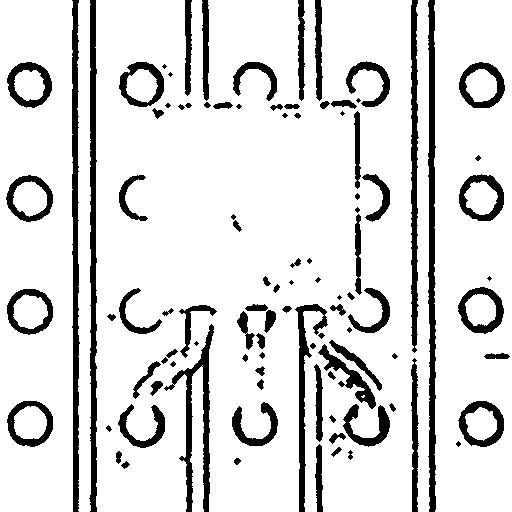

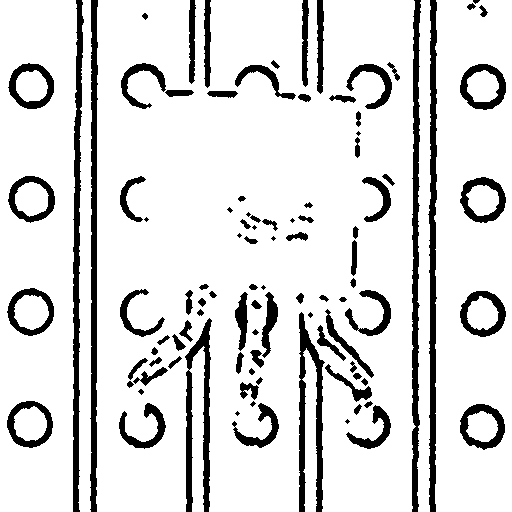

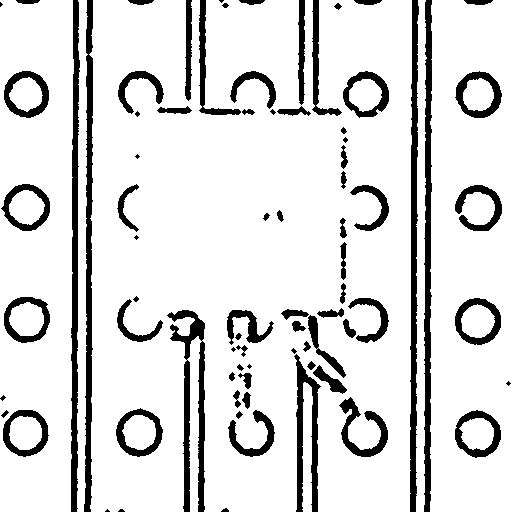

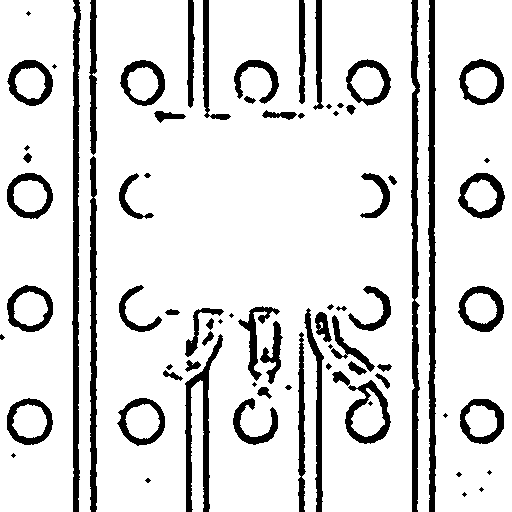

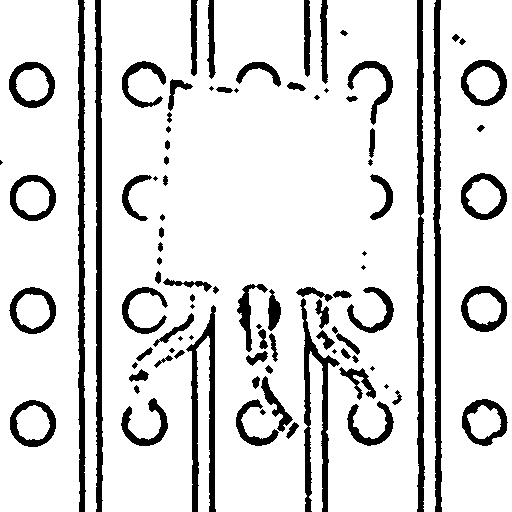

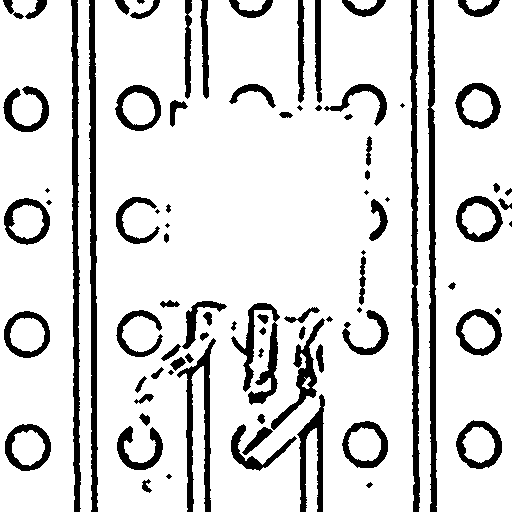

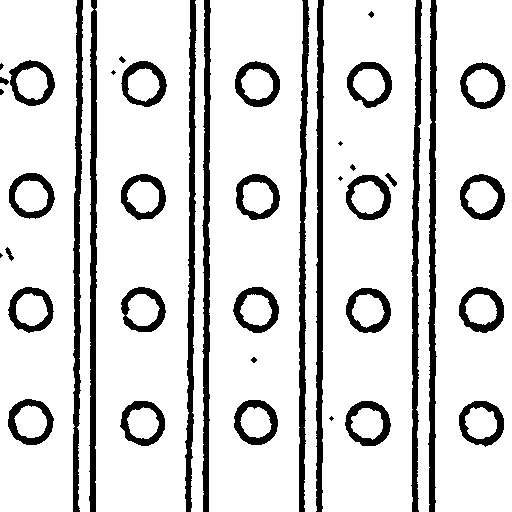

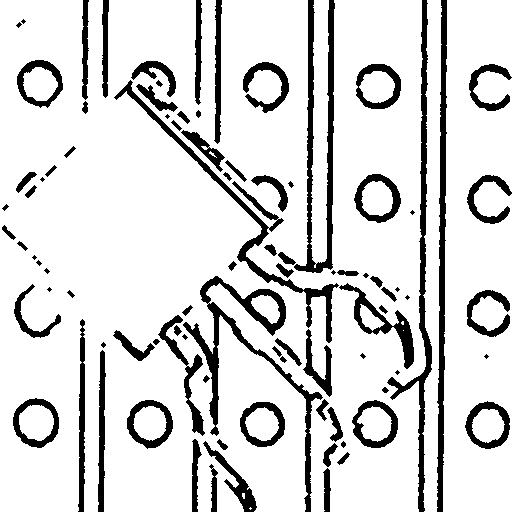

In [11]:
train_images = load_imgs(trainImg,512)
test_images = load_imgs(testImg, 512)

show_img_bin(testImg,True)


Sprawdzam obecność zaszumienia -

In [12]:
from skimage.feature import hog
def get_HOG_features(img, orientations, pixels_per_cell,cells_per_block):
  fd, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=True, multichannel=True)
  return fd

In [13]:
train_images = load_imgs(trainImg,256)
test_images = load_imgs(testImg, 256)

trainDisc = [get_HOG_features(img, 9, (8,8),(2,2)) for img in train_images]
testDisc =[get_HOG_features(img, 9, (8,8),(2,2)) for img in test_images]

<ipython-input-12-45b6aaa57843>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=True, multichannel=True)


In [14]:
print(trainDisc)

[array([0.34605386, 0.00876893, 0.00831893, ..., 0.14761213, 0.05787128,
       0.06285058]), array([0.35105269, 0.01314177, 0.01463171, ..., 0.13065512, 0.05902397,
       0.10903392]), array([0.30073477, 0.04873963, 0.01346147, ..., 0.22551587, 0.10025889,
       0.05117529]), array([0.23029311, 0.06510875, 0.08080608, ..., 0.2337742 , 0.10672693,
       0.03272331]), array([0.15726102, 0.        , 0.        , ..., 0.12528084, 0.21678569,
       0.10087144]), array([0.19397994, 0.07745577, 0.12295339, ..., 0.1211148 , 0.11558087,
       0.03868871]), array([0.34912064, 0.0096781 , 0.02142339, ..., 0.22767323, 0.05276866,
       0.        ]), array([0.18920585, 0.02804538, 0.15478601, ..., 0.23496223, 0.11841352,
       0.0418655 ]), array([0.25588322, 0.0576216 , 0.04773689, ..., 0.16441429, 0.08564723,
       0.07878032]), array([0.17570767, 0.06617043, 0.03392392, ..., 0.12918749, 0.08754144,
       0.20633715]), array([0.19413142, 0.        , 0.11153321, ..., 0.06594728, 0.1149153

In [15]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='linear')
clf.fit(trainDisc, trainLabels)

testPred = clf.predict(testDisc)


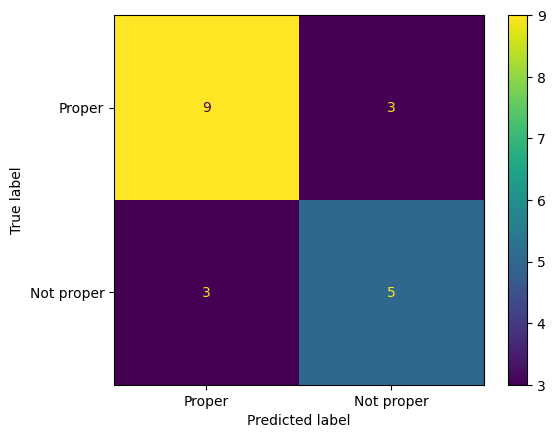

              precision    recall  f1-score   support

      Proper       0.75      0.75      0.75        12
  Not proper       0.62      0.62      0.62         8

    accuracy                           0.70        20
   macro avg       0.69      0.69      0.69        20
weighted avg       0.70      0.70      0.70        20



In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(testLabels,testPred)
target_names = ['Proper','Not proper']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = target_names)
disp.plot()
plt.show()

print(classification_report(testLabels, testPred, target_names=target_names))

Results for image size 128x128

<ipython-input-12-45b6aaa57843>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=True, multichannel=True)


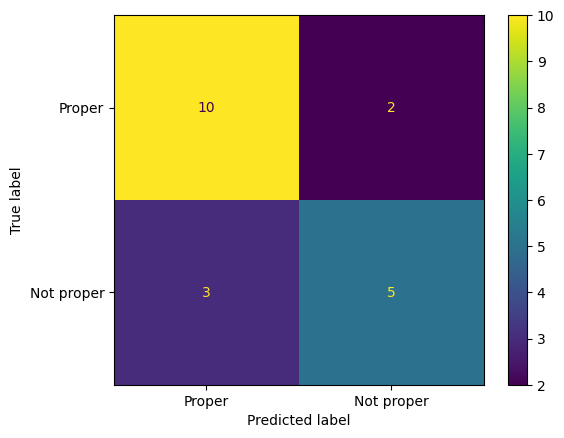

              precision    recall  f1-score   support

      Proper       0.77      0.83      0.80        12
  Not proper       0.71      0.62      0.67         8

    accuracy                           0.75        20
   macro avg       0.74      0.73      0.73        20
weighted avg       0.75      0.75      0.75        20



In [17]:

train_images = load_imgs(trainImg,128)
test_images = load_imgs(testImg, 128)

trainDisc = [get_HOG_features(img, 9, (8,8),(2,2)) for img in train_images]
testDisc =[get_HOG_features(img, 9, (8,8),(2,2)) for img in test_images]
clf = svm.SVC(kernel='linear')
clf.fit(trainDisc, trainLabels)

testPred = clf.predict(testDisc)

cm = confusion_matrix(testLabels,testPred)
target_names = ['Proper','Not proper']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = target_names)
disp.plot()
plt.show()

print(classification_report(testLabels, testPred, target_names=target_names))

<ipython-input-12-45b6aaa57843>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=True, multichannel=True)


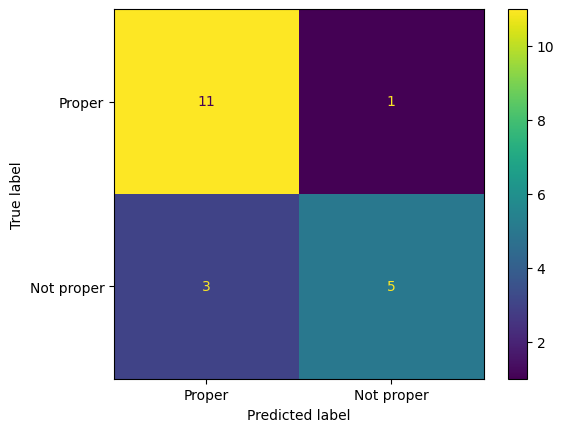

              precision    recall  f1-score   support

      Proper       0.79      0.92      0.85        12
  Not proper       0.83      0.62      0.71         8

    accuracy                           0.80        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.80      0.80      0.79        20



In [18]:
train_images = load_imgs(trainImg,64)
test_images = load_imgs(testImg, 64)

trainDisc = [get_HOG_features(img, 9, (8,8),(2,2)) for img in train_images]
testDisc =[get_HOG_features(img, 9, (8,8),(2,2)) for img in test_images]
clf = svm.SVC(kernel='linear')
clf.fit(trainDisc, trainLabels)

testPred = clf.predict(testDisc)

cm = confusion_matrix(testLabels,testPred)
target_names = ['Proper','Not proper']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = target_names)
disp.plot()
plt.show()

print(classification_report(testLabels, testPred, target_names=target_names))

Klasyfikując obrazy za pomocą SVM biorąc wyniki algorytmu HOG jako dane uczące, udało się osiągnąć 80% dokładność modelu.

**ZADANIE 2**

In [19]:
from google.colab.patches import cv2_imshow
def show_img_bin(img_paths):
  for path in img_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    binary_img = cv2.adaptiveThreshold(np.array(img), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
    cv2_imshow(binary_img)

# Test 1. - Czy wszystkie otwory zajęte 


*   Crop 1,2,3
*   Test 1,2,3
*   if 3 - Good 

# Test 2. - Czy nie rozwalony plastik
* Crop obudowa
* Test wsp. kształtu


In [20]:
def crop_frame(img_list,x1,x2,y1,y2):
  c_img = [img[x1:x2,y1:y2] for img in img_list]
  return c_img

In [21]:
def get_treshold(im):
  
  T = np.mean(im)
  while(1):
    higher = im.copy() 
    lower = im.copy()
    
    higher[higher<T]=0
    lower[lower>=T]=0

    N_h = np.count_nonzero(higher)
    N_l = np.count_nonzero(lower)

    mean_h = np.sum(higher)/N_h
    mean_l = np.sum(lower)/N_l

    T1 = (mean_h + mean_l)/2

    if (T1-T)<1:
      T = int(T1)
      break
    else: 
      T = int(T1)
  
  return T

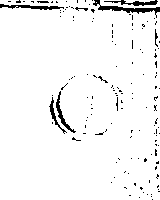

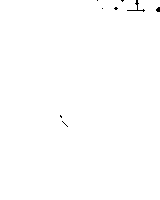

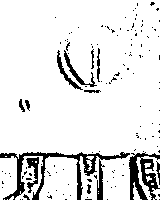

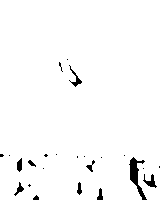

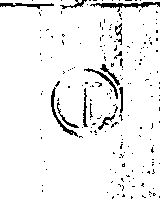

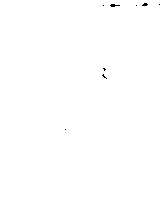

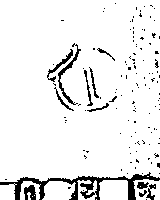

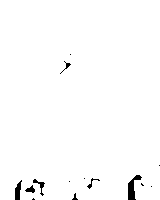

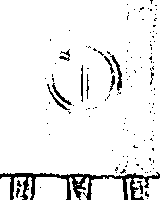

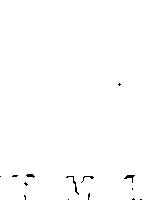

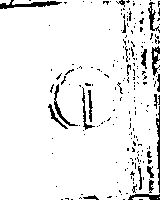

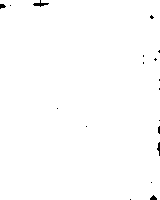

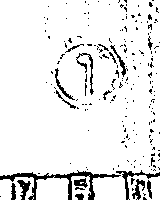

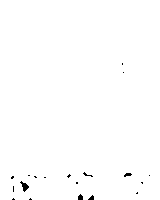

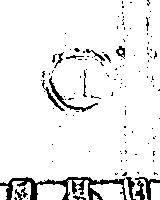

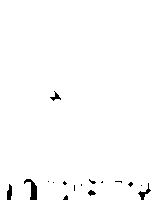

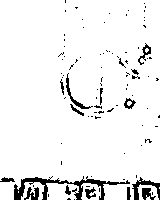

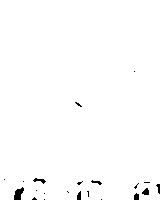

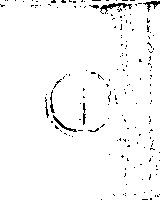

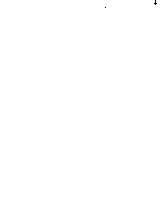

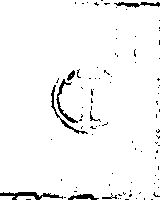

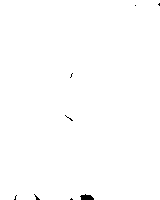

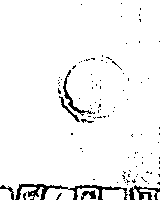

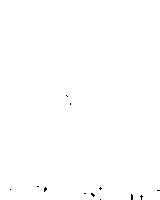

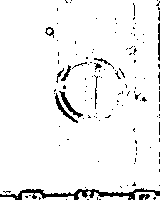

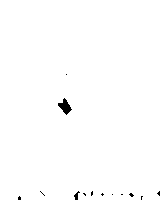

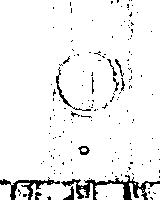

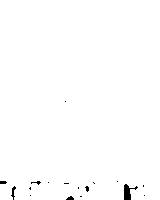

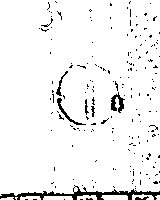

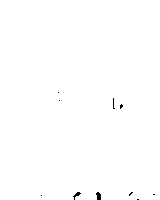

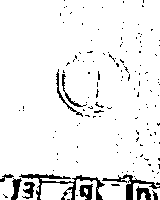

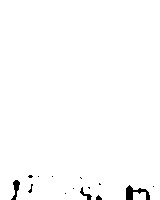

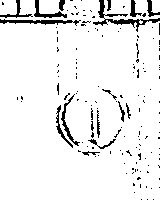

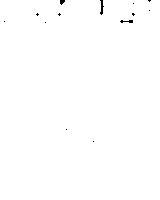

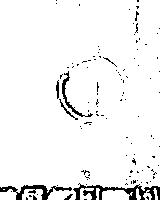

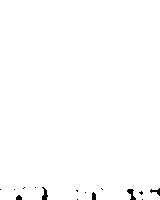

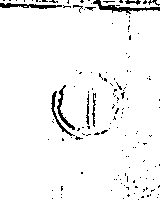

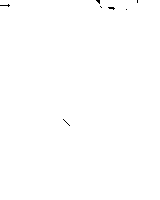

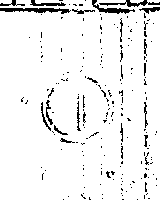

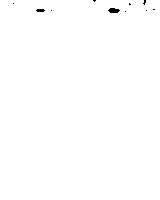

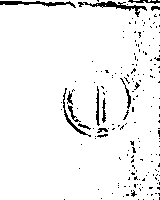

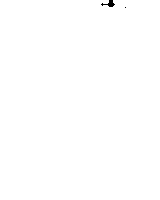

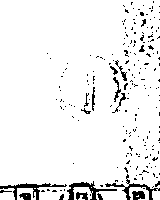

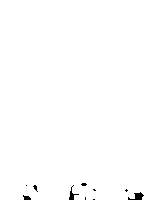

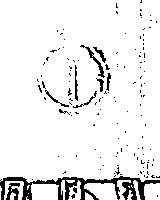

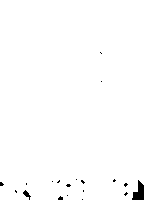

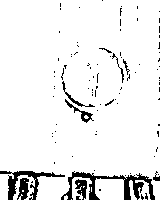

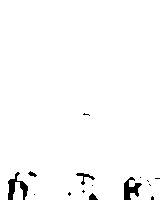

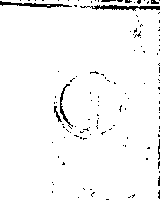

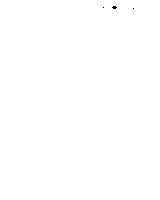

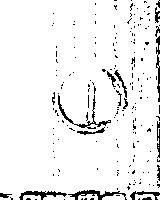

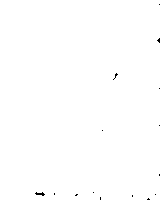

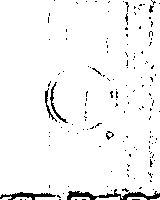

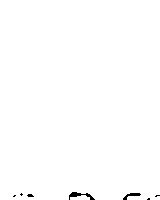

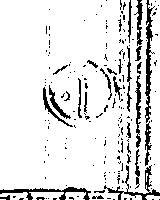

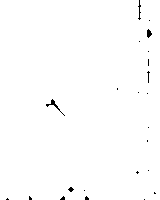

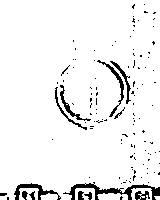

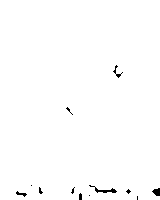

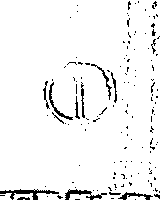

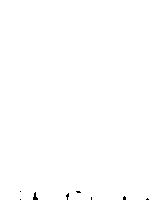

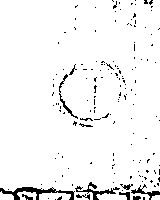

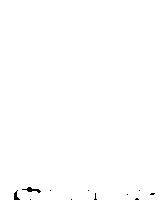

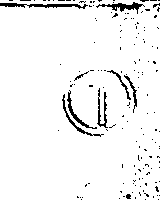

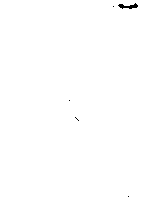

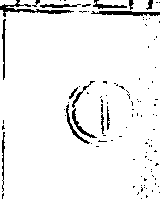

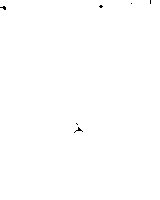

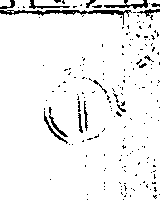

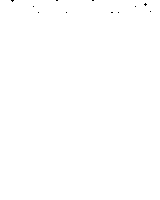

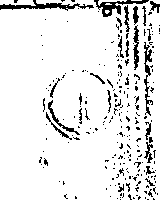

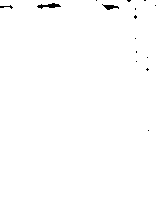

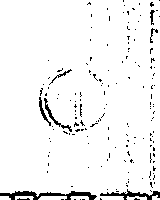

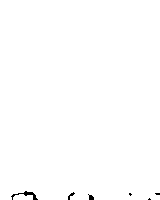

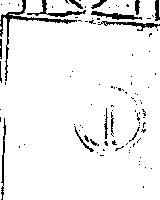

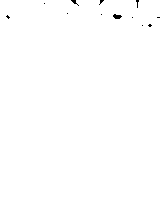

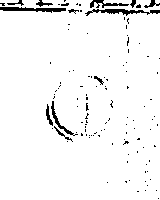

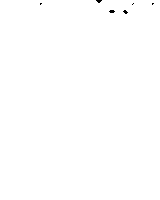

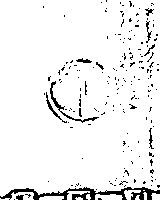

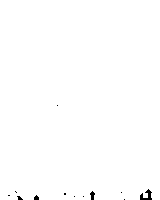

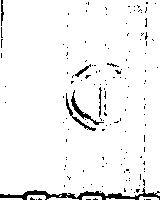

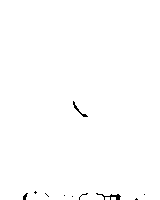

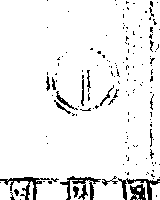

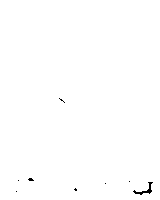

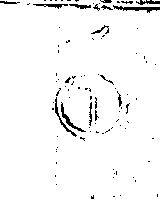

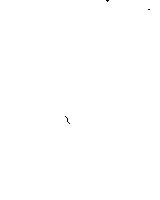

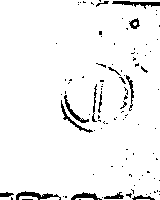

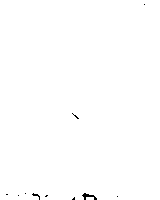

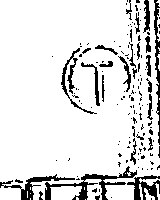

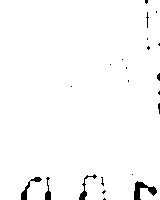

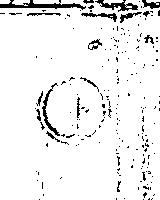

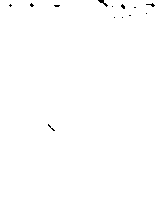

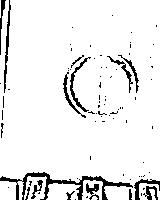

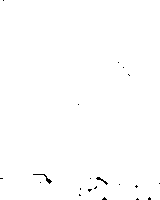

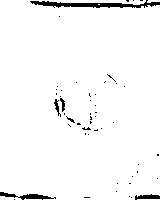

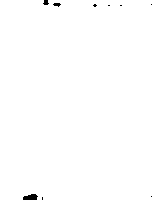

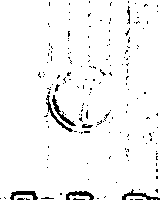

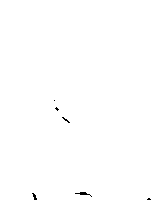

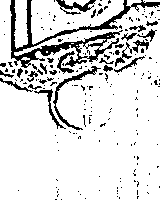

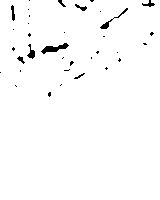

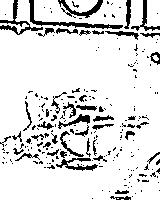

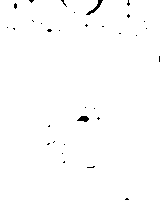

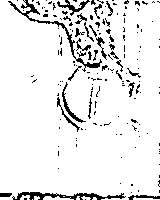

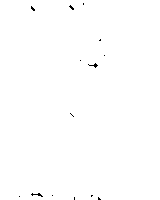

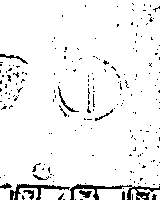

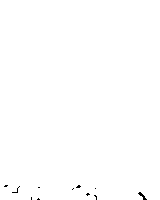

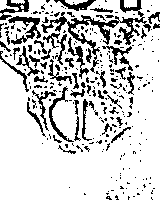

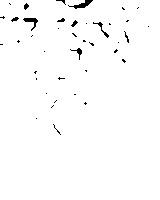

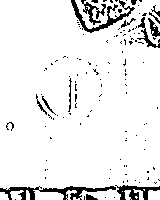

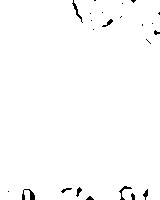

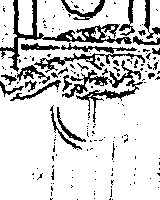

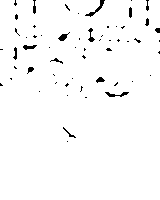

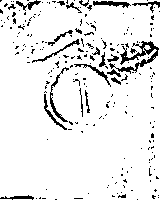

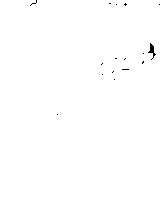

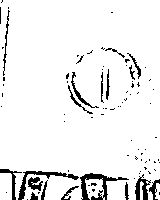

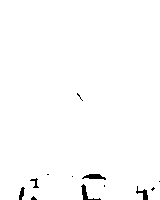

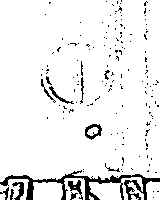

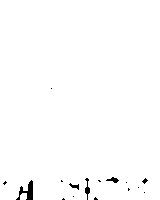

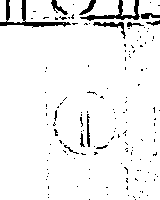

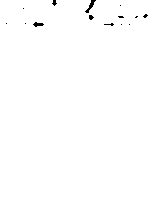

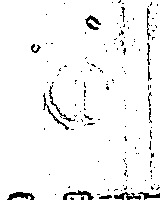

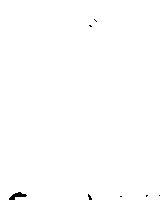

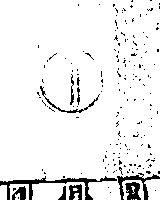

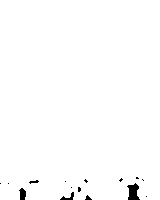

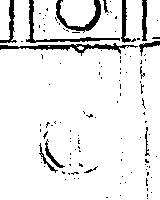

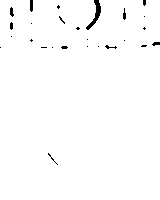

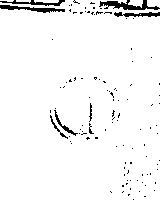

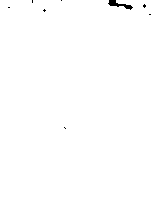

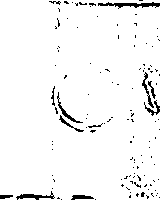

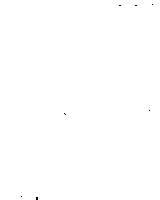

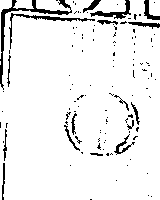

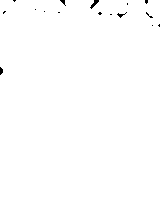

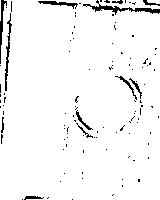

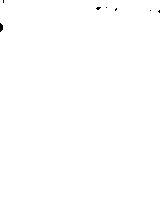

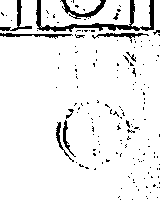

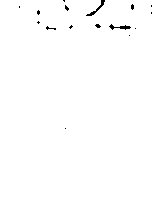

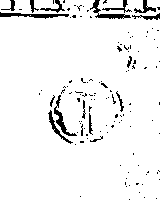

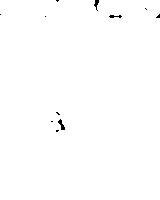

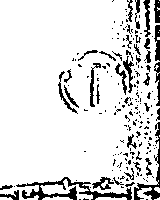

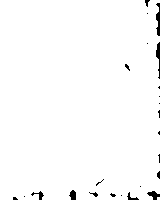

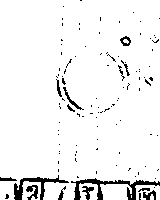

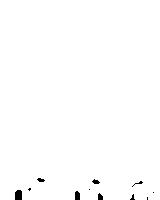

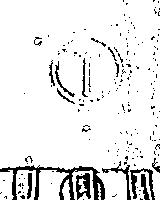

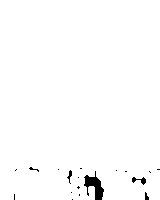

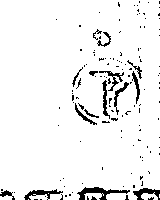

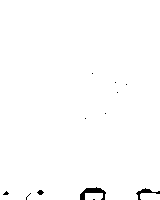

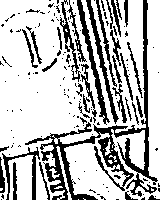

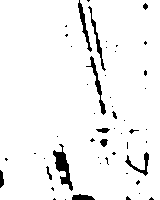

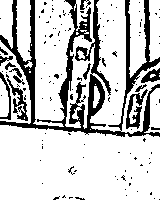

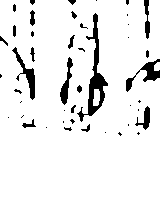

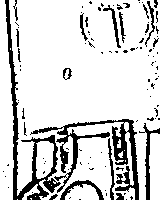

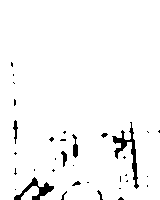

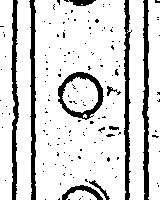

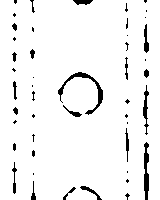

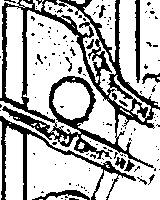

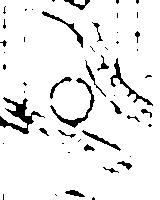

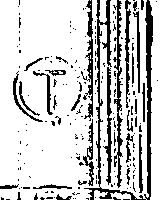

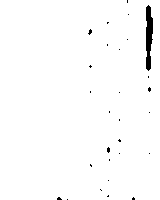

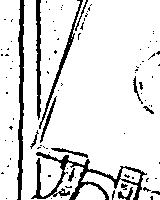

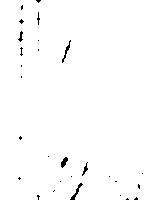

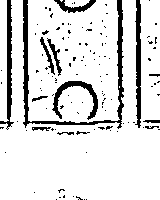

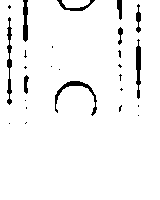

In [62]:
test_images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in trainImg]

test_images = [cv2.medianBlur(img,3) for img in test_images]
crop_base = crop_frame(test_images,100,300,175,335)
crop_hole_1 = crop_frame(test_images,390,460,110,180)
crop_hole_2 = crop_frame(test_images,390,460,220,290)
crop_hole_3 = crop_frame(test_images,390,460,330,410)

b_crop_base = [cv2.adaptiveThreshold(np.array(img), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) for img in crop_base]
b_crop_hole_1 = [cv2.adaptiveThreshold(np.array(img), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) for img in crop_hole_1]
b_crop_hole_2 = [cv2.adaptiveThreshold(np.array(img), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) for img in crop_hole_2]
b_crop_hole_3 = [cv2.adaptiveThreshold(np.array(img), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) for img in crop_hole_3]

for im in b_crop_base:
  im2 =im.copy()
  kernel1 = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

  im = cv2.dilate(im,kernel1,iterations = 2)
  im = cv2.erode(im,kernel1,iterations = 4)
  im = cv2.dilate(im,kernel2,iterations = 2)

  cv2_imshow(im2)
  cv2_imshow(im)

